<a href="https://colab.research.google.com/github/ssv273/NN_intro/blob/master/HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Downloadig dataset

In [0]:
# import json
# with open('/content/kaggle.json', 'r', encoding='utf-8') as fh:
#     data = json.load(fh)

In [0]:
# import os
# os.environ['KAGGLE_USERNAME'] = data['username']
# os.environ['KAGGLE_KEY'] = data['key']
# !kaggle competitions download -c dogs-vs-cats

In [0]:
# !unzip test1.zip -d /content/competitions/dogs-vs-cats

In [0]:
# !unzip train.zip -d /content/competitions/dogs-vs-cats

# Import libraries

In [0]:
import matplotlib.pyplot as plt
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers import BatchNormalization
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Looking at pictures

In [0]:
filenames = os.listdir("/content/competitions/dogs-vs-cats/train")

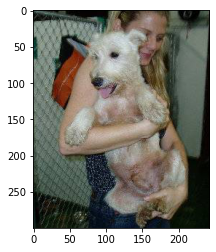

In [10]:
sample = random.choice(filenames)
image = load_img("/content/competitions/dogs-vs-cats/train/"+sample)
plt.imshow(image)

In [11]:
for i in range(10):
  sample = random.choice(filenames)  
  im = Image.open("/content/competitions/dogs-vs-cats/train/"+sample)
  print(im.size)

(324, 242)
(160, 159)
(423, 499)
(374, 500)
(287, 256)
(499, 375)
(499, 375)
(499, 412)
(459, 499)
(500, 374)


Как мы видим - изображения имеют разный размер. Поэтому зададим им размер 128х128

In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Preparing dataset

In [0]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})



In [14]:
df.head()

,filename,category
0,dog.7437.jpg,1
1,dog.1269.jpg,1
2,dog.2768.jpg,1
3,dog.7531.jpg,1
4,cat.7918.jpg,0


Посмотрим на распределение классов

1    12500
0    12500
Name: category, dtype: int64


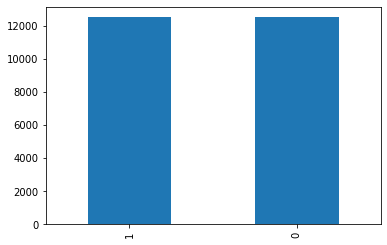

In [15]:
print(df['category'].value_counts())
df['category'].value_counts().plot.bar();

Как мы видим классы сбалансированы

# Building model

In [0]:
model = Sequential()

# По архитектуре AlexNet сначала идёт свертка большим ядром, пусть у нас будет 8x8
model.add(Conv2D(96, (8, 8),strides=3, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# тогда получается в следующем слое 41х41х96

# затем идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 20х20х96

# дальше опять свертка с ядром поменьше
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
# тогда получается в следующем слое 20х20х256

# затем опять идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 9х9х256

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 41, 96)        18528     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 256)         884992    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0

# Prepare data

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [23]:


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 5000 validated image filenames belonging to 2 classes.


In [24]:


example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)



Found 1 validated image filenames belonging to 1 classes.


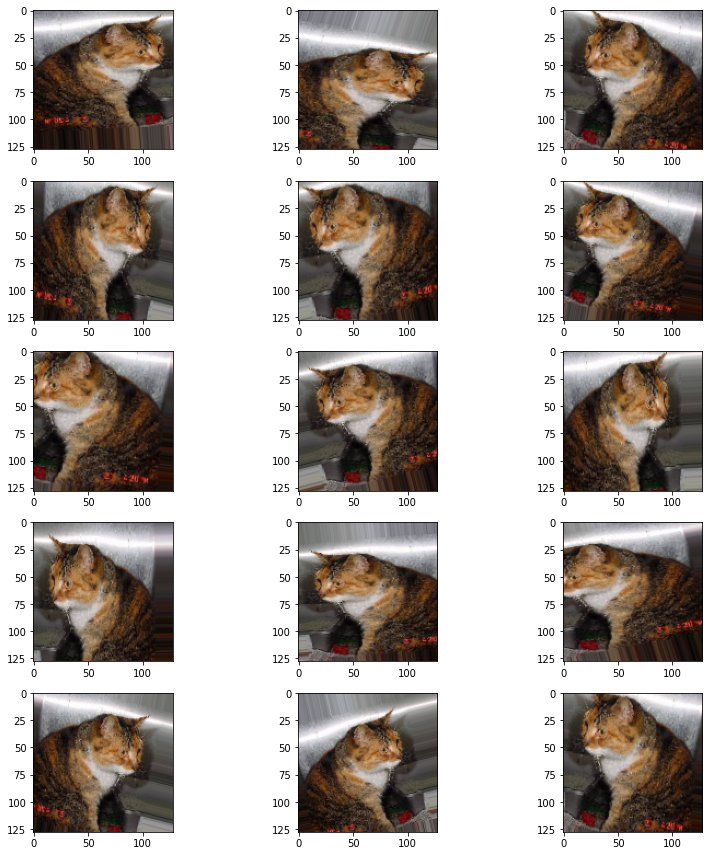

In [25]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit model


In [26]:
epochs=5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/5
1333/1333 [==============================] - 139s 104ms/step - loss: 1.1054 - accuracy: 0.5059 - val_loss: 0.6928 - val_accuracy: 0.5077
Epoch 2/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.7027 - accuracy: 0.5160 - val_loss: 0.6825 - val_accuracy: 0.5628
Epoch 3/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.6994 - accuracy: 0.5634 - val_loss: 0.6677 - val_accuracy: 0.6068
Epoch 4/5
1333/1333 [==============================] - 135s 102ms/step - loss: 0.6756 - accuracy: 0.6041 - val_loss: 0.6525 - val_accuracy: 0.6140
Epoch 5/5
1333/1333 [==============================] - 137s 103ms/step - loss: 0.6550 - accuracy: 0.6348 - val_loss: 0.6235 - val_accuracy: 0.6474


# Save model

In [0]:
model.save_weights("model.h5")

# Virtualize Training

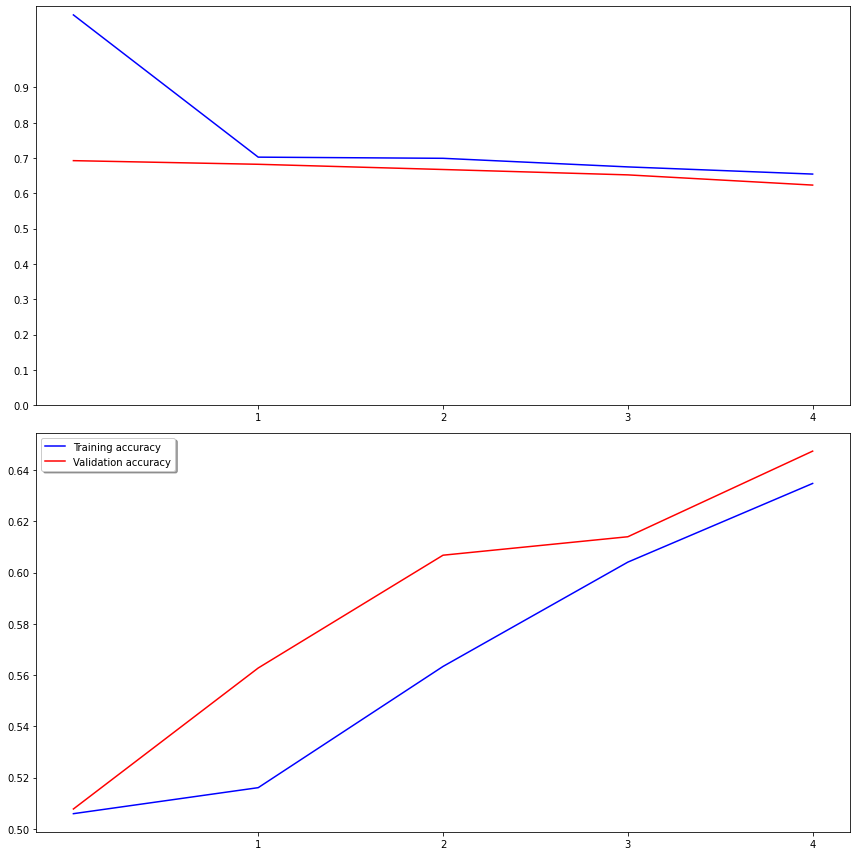

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Добавим нормализацию

In [0]:
model = Sequential()

# По архитектуре AlexNet сначала идёт свертка большим ядром, пусть у нас будет 8x8
model.add(Conv2D(96, (8, 8),strides=3, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# тогда получается в следующем слое 41х41х96

# затем идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 20х20х96

# добавим нормализацию
model.add(BatchNormalization())

# дальше опять свертка с ядром поменьше
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
# тогда получается в следующем слое 20х20х256

# затем опять идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 9х9х256

# добавим нормализацию
model.add(BatchNormalization())

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# добавим нормализацию
model.add(BatchNormalization())

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [31]:
epochs=5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/5
1333/1333 [==============================] - 140s 105ms/step - loss: 0.9183 - accuracy: 0.5959 - val_loss: 0.6926 - val_accuracy: 0.6637
Epoch 2/5
1333/1333 [==============================] - 137s 103ms/step - loss: 0.5795 - accuracy: 0.7056 - val_loss: 0.9852 - val_accuracy: 0.5884
Epoch 3/5
1333/1333 [==============================] - 137s 103ms/step - loss: 0.5028 - accuracy: 0.7654 - val_loss: 0.4361 - val_accuracy: 0.7988
Epoch 4/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.4539 - accuracy: 0.7981 - val_loss: 0.4894 - val_accuracy: 0.7938
Epoch 5/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.4248 - accuracy: 0.8138 - val_loss: 0.3756 - val_accuracy: 0.8484


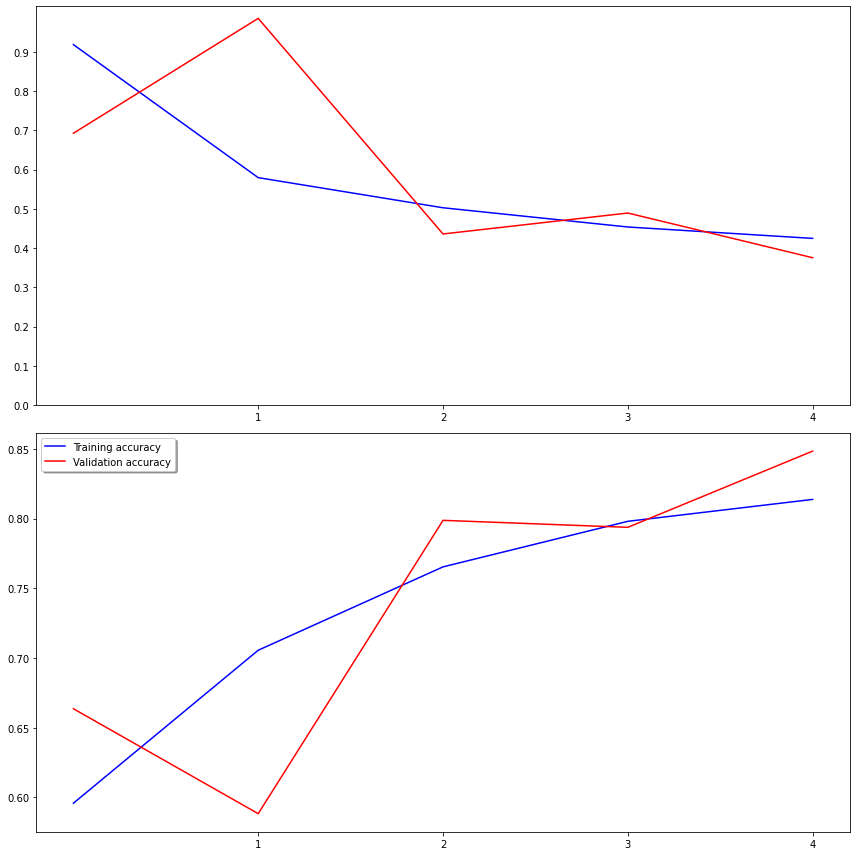

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Добавим дропаут

In [0]:
model = Sequential()

# По архитектуре AlexNet сначала идёт свертка большим ядром, пусть у нас будет 8x8
model.add(Conv2D(96, (8, 8),strides=3, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# тогда получается в следующем слое 41х41х96

# затем идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 20х20х96

# добавим нормализацию
model.add(BatchNormalization())

# дальше опять свертка с ядром поменьше
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
# тогда получается в следующем слое 20х20х256

# затем опять идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 9х9х256

# добавим нормализацию
model.add(BatchNormalization())

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# добавим нормализацию
model.add(BatchNormalization())

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2048))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [35]:
epochs=5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/5
1333/1333 [==============================] - 137s 103ms/step - loss: 0.9555 - accuracy: 0.5845 - val_loss: 0.6895 - val_accuracy: 0.5552
Epoch 2/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.6403 - accuracy: 0.6738 - val_loss: 1.2586 - val_accuracy: 0.5439
Epoch 3/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.5761 - accuracy: 0.7235 - val_loss: 1.2700 - val_accuracy: 0.5998
Epoch 4/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.5452 - accuracy: 0.7490 - val_loss: 0.5335 - val_accuracy: 0.7594
Epoch 5/5
1333/1333 [==============================] - 136s 102ms/step - loss: 0.5260 - accuracy: 0.7654 - val_loss: 0.5068 - val_accuracy: 0.8296


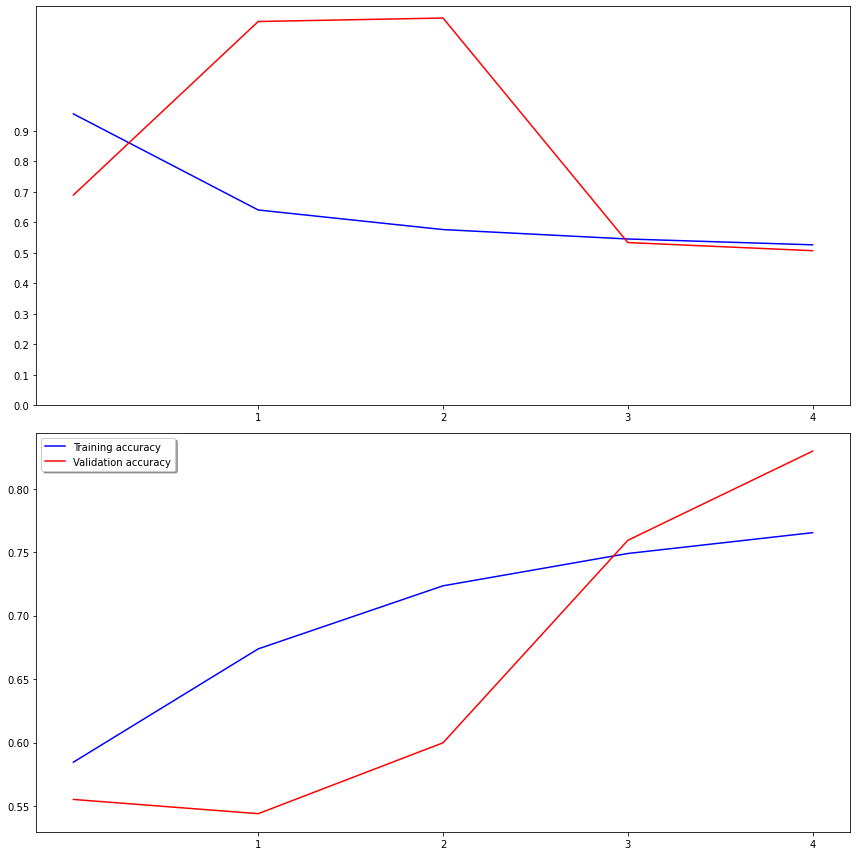

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Добавим слои

In [0]:
model = Sequential()

# По архитектуре AlexNet сначала идёт свертка большим ядром, пусть у нас будет 8x8
model.add(Conv2D(96, (8, 8),strides=3, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# тогда получается в следующем слое 41х41х96

# затем идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 20х20х96

# добавим нормализацию
model.add(BatchNormalization())

# дальше опять свертка с ядром поменьше
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
# тогда получается в следующем слое 20х20х256

# затем опять идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 9х9х256

# добавим нормализацию
model.add(BatchNormalization())

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
# model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
# model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# затем идут 2 подряд свертки
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256


# добавим нормализацию
model.add(BatchNormalization())

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2048))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [48]:
epochs=25
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/25
1333/1333 [==============================] - 167s 125ms/step - loss: 0.5119 - accuracy: 0.7674 - val_loss: 0.6228 - val_accuracy: 0.6356
Epoch 2/25
1333/1333 [==============================] - 166s 125ms/step - loss: 0.4888 - accuracy: 0.7861 - val_loss: 0.4101 - val_accuracy: 0.8426
Epoch 3/25
1333/1333 [==============================] - 166s 125ms/step - loss: 0.4732 - accuracy: 0.7953 - val_loss: 0.3800 - val_accuracy: 0.8507
Epoch 4/25
1333/1333 [==============================] - 166s 124ms/step - loss: 0.4650 - accuracy: 0.8045 - val_loss: 0.4581 - val_accuracy: 0.8280
Epoch 5/25
1333/1333 [==============================] - 165s 124ms/step - loss: 0.4430 - accuracy: 0.8164 - val_loss: 0.3818 - val_accuracy: 0.8509
Epoch 6/25
1333/1333 [==============================] - 165s 124ms/step - loss: 0.4353 - accuracy: 0.8182 - val_loss: 0.5225 - val_accuracy: 0.7716
Epoch 7/25
1333/1

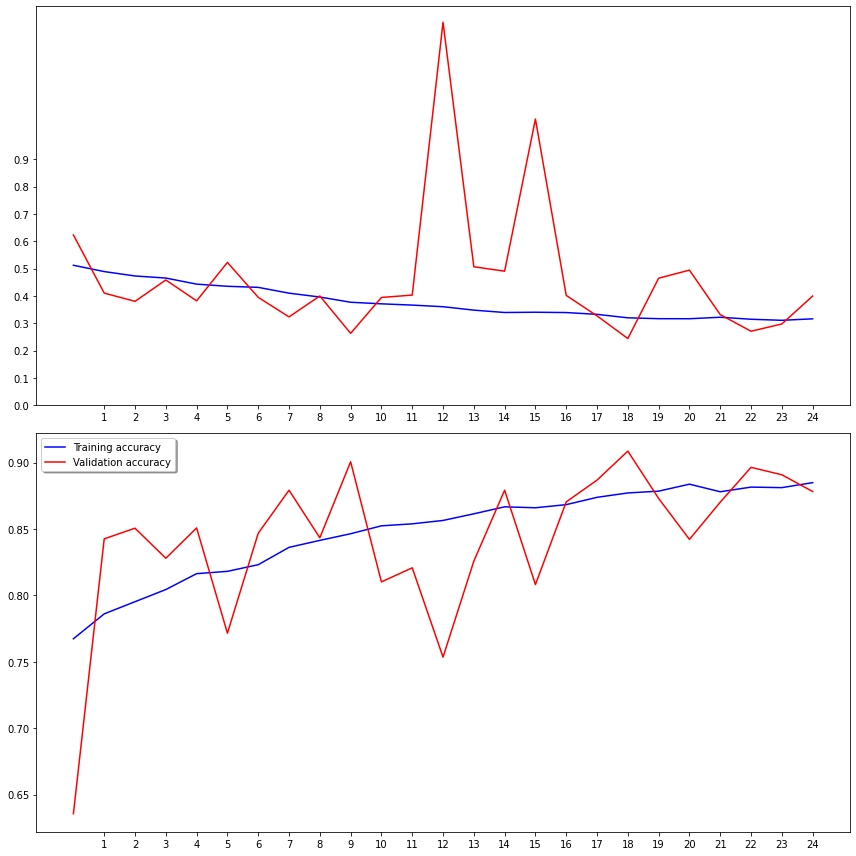

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Попробуем увеличить число ядер

In [0]:
model = Sequential()

# По архитектуре AlexNet сначала идёт свертка большим ядром, пусть у нас будет 8x8
model.add(Conv2D(512, (8, 8),strides=3, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# тогда получается в следующем слое 41х41х512

# затем идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 20х20х512

# добавим нормализацию
model.add(BatchNormalization())

# дальше опять свертка с ядром поменьше
model.add(Conv2D(1024, (5, 5), activation='relu', padding='same'))
# тогда получается в следующем слое 20х20х1024

# затем опять идет пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 9х9х256

# добавим нормализацию
model.add(BatchNormalization())

# затем идут 2 подряд свертки
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х384
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# тогда получается в следующем слое 9х9х256

# затем опять пулинг
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# тогда получается в следующем слое 4х4х256

# добавим нормализацию
model.add(BatchNormalization())

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2048))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [44]:
epochs=5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/5
1333/1333 [==============================] - 169s 127ms/step - loss: 0.9535 - accuracy: 0.5753 - val_loss: 1.3925 - val_accuracy: 0.5247
Epoch 2/5
1333/1333 [==============================] - 166s 124ms/step - loss: 0.6499 - accuracy: 0.6624 - val_loss: 0.6750 - val_accuracy: 0.7365
Epoch 3/5
1333/1333 [==============================] - 166s 125ms/step - loss: 0.5972 - accuracy: 0.7074 - val_loss: 0.7095 - val_accuracy: 0.5960
Epoch 4/5
1333/1333 [==============================] - 165s 124ms/step - loss: 0.5561 - accuracy: 0.7371 - val_loss: 0.4342 - val_accuracy: 0.8160
Epoch 5/5
1333/1333 [==============================] - 170s 128ms/step - loss: 0.5292 - accuracy: 0.7521 - val_loss: 0.4340 - val_accuracy: 0.7986


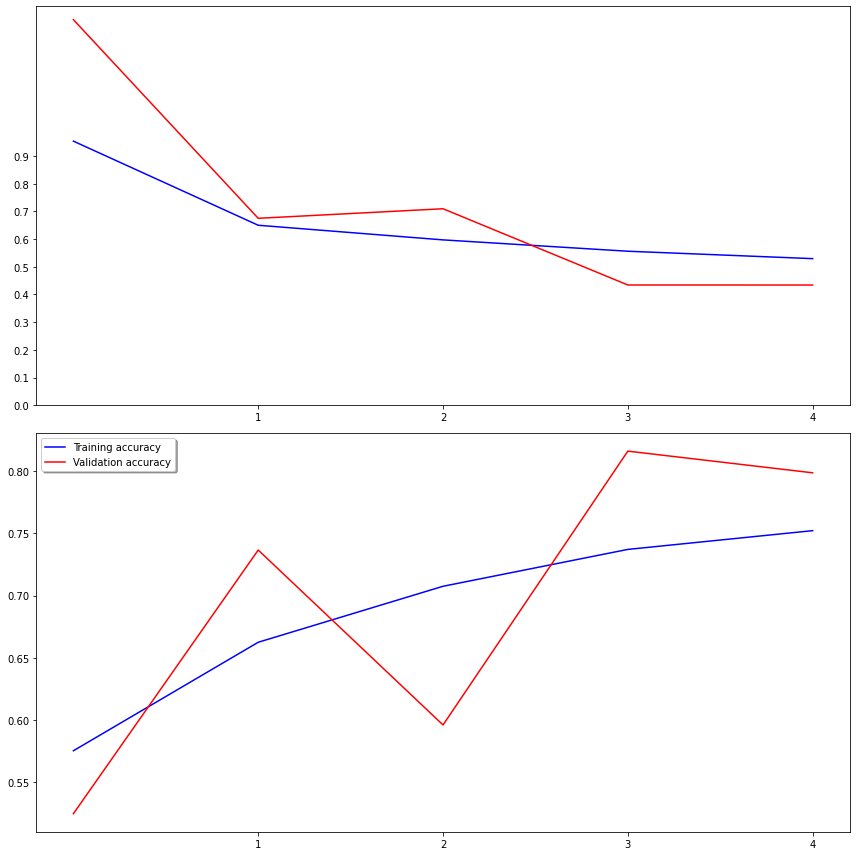

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
from tensorflow.keras.utils import plot_model

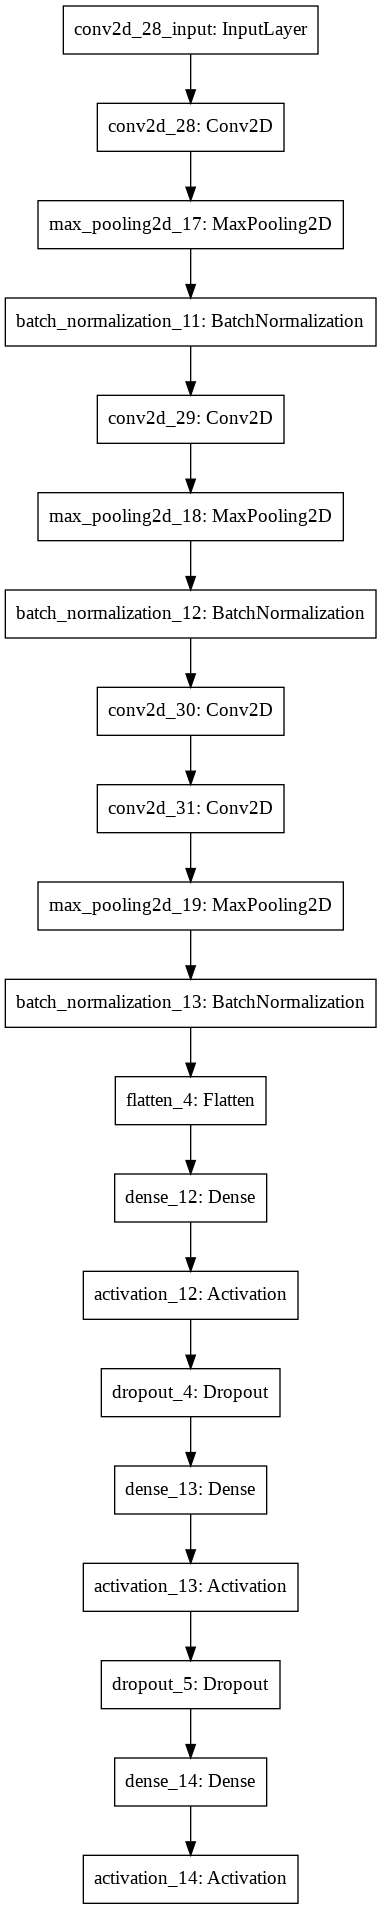

In [47]:
plot_model(model)

# Выводы

1. Нормализация очень сильно влияет на точность сети
2. Увеличение числа ядер дает какой-то рандомный эффект на валидационной выборке. Скорее всего это означает что сеть не обобщает признаки, а подстраивается под тренировочную выборку.
3. Увеличение слоев дает вроде как увеличение точности, но это не точно.
4. Увеличение количества эпох повышает точность сети